# Elevation

This notebook uses .river_elevation to find the elevations of a chosen river. Such data was then used to determine the relative elevations for the buildings within the same reason. This is the output of the code within the MODULE module of this code. 


This notebook demonstrates why the building elevation module was structured as it was, showing the different ways that could have been used.

In [1]:
#pip install ipywidgets

In [2]:
import hazards
import rasterio 
import rasterio.windows as window
import numpy as np 
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib as mpl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%matplotlib inline
from IPython.display import display 
from ipywidgets import interactive, widgets
import osmnx as ox

## Variables for the following functions

In [4]:
north = 55.6658  # North latitude
south = 55.6372  # South latitude
east = -3.1651   # East longitude
west = -3.2116   # West longitude

name = 'Exeter'
geotiff_path = 'Peebles-30m-DEM.tif'

In [5]:
r = hazards.river_elevation(geotiff_path, north, south, east, west, buffer = 0.005)

Processing rivers in lat long grid
2 Unique Rivers Extracted:
       River Tweed
       Eddleston Water


In [6]:
min_value = float('inf')
max_value = float('-inf')
for row in r['elevations']:
    for value in row:
        if value < min_value:
            min_value = value 
        if value > max_value:
            max_value = value
            
print(f'Min value = {min_value}')
print(f'Max value = {max_value}')

Min value = 156
Max value = 181


# Simple Building Elevations

This is the relative building elevations assuming that the river profile is flat enough that using one value for the river height is a good enough approximation along the river. This method is evaluated in a lower area for Peebles in particular, but is clearly an over simplified method for many areas that would not have a relatively flat river bed. 

This could be a good approximation in some areas, particularly in smaller, flat regions. 

In [7]:
def mean_of_lists(lists):
    total_sum = 0
    total_count = 0

    for lst in lists:
        sublist_sum = sum(lst)  # Calculate the sum of elements in the current list
        total_sum += sublist_sum
        total_count += len(lst)  # Add the length of the sublist to the total count

    # Calculate the mean
    if total_count > 0:
        mean = total_sum / total_count
    else:
        mean = 0  # To handle the case where there are no elements in the lists

    return mean

In [8]:
buildings = ox.features_from_bbox(north, south, east, west, tags={'building' : True})

In [9]:
buildings['centroid'] = (buildings['geometry'].to_crs(crs=3857).centroid).to_crs(crs=4326) 
coords_list = [(point.x, point.y) for point in buildings['centroid']] 
#This warning is less relevant as they are small buildings. 
#But should do this anyway

In [10]:
elev = []

with rasterio.open(geotiff_path) as src:
    vals = src.sample(coords_list)
    for val in vals:
        elev.append(val[0])

In [11]:
buildings['elevations'] = elev

In [12]:
buildings['simple elevation'] = elev - mean_of_lists(r['elevations'])
buildings = buildings[['geometry', 'centroid' ,'building', 'elevations', 'simple elevation']]
buildings

geometry  \
element_type osmid                                                           
node         8725451306                          POINT (-3.19199 55.65146)   
way          105014833   POLYGON ((-3.17966 55.64493, -3.17952 55.64491...   
             105014843   POLYGON ((-3.17991 55.64526, -3.17998 55.64500...   
             105014989   POLYGON ((-3.17996 55.64495, -3.17985 55.64494...   
             105014996   POLYGON ((-3.17980 55.64494, -3.17970 55.64493...   
...                                                                    ...   
relation     1534123     POLYGON ((-3.20805 55.64243, -3.20802 55.64241...   
             12361113    POLYGON ((-3.18941 55.64134, -3.18944 55.64142...   
             12625333    POLYGON ((-3.18661 55.64999, -3.18661 55.65001...   
             12648541    POLYGON ((-3.19274 55.66248, -3.19267 55.66249...   
             12706360    POLYGON ((-3.17829 55.65272, -3.17829 55.65274...   

                                          centroid        building  \
element_type osmid                                                   
node         8725451306  POINT (-3.19199 55.65146)             yes   
way          105014833   POINT (-3.17962 55.64482)          school   
             105014843   POINT (-3.17940 55.64522)          school   
             105014989   POINT (-3.17993 55.64485)          school   
             105014996   POINT (-3.17976 55.64489)          school   
...                                            ...             ...   
relation     1534123     POINT (-3.20798 55.64219)  farm_auxiliary   
             12361113    POINT (-3.18932 55.64141)           house   
             12625333    POINT (-3.18659 55.64999)            shed   
             12648541    POINT (-3.19271 55.66244)           house   
             12706360    POINT (-3.17700 55.65273)             yes   

                         elevations  simple elevation  
element_type osmid                                     
node         8725451306         169          3.380208  
way          105014833          164         -1.619792  
             105014843          162         -3.619792  
             105014989          164         -1.619792  
             105014996          163         -2.619792  
...                             ...               ...  
relation     1534123            224         58.380208  
             12361113           197         31.380208  
             12625333           160         -5.619792  
             12648541           177         11.380208  
             12706360           195         29.380208  

[4475 rows x 5 columns]

In [13]:
colourmap = np.arange(buildings['simple elevation'].min(), buildings['simple elevation'].max(), 5)

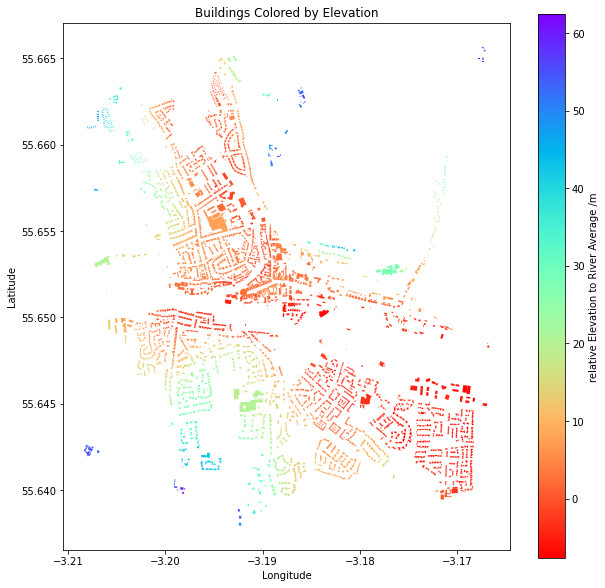

In [14]:
cmap = plt.get_cmap('rainbow_r')

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons and color them based on the 'simple elevation' column
buildings.plot(column='simple elevation', cmap=cmap, ax=ax)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Buildings Colored by Elevation')

# Get the ScalarMappable object from the plot
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(colourmap)  # Set a dummy array
#sm=np.array(buildings['simple elevation'])

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax, label='relative Elevation to River Average /m')


# Display the plot
plt.show()

This does show that most of the buildings within Peebles are within the -5 to 10m elevation from the river elevation. 

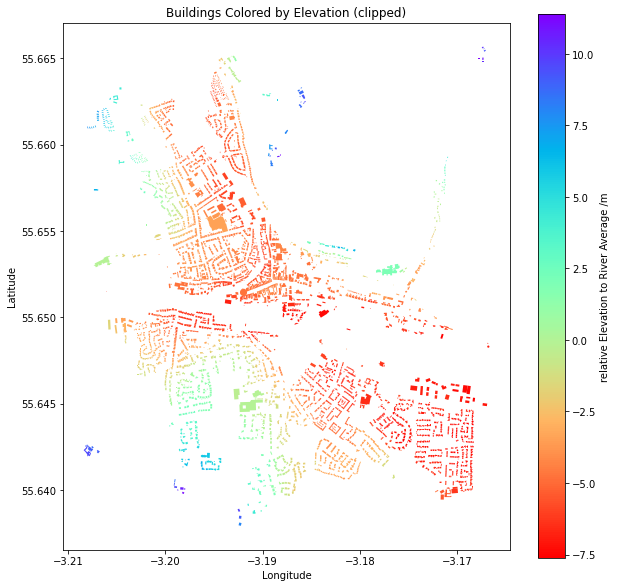

In [15]:
colourmap = np.arange(buildings['simple elevation'].min(), buildings['simple elevation'].min() + 20,1)
cmap = plt.get_cmap('rainbow_r')

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons and color them based on the 'simple elevation' column
buildings.plot(column='simple elevation', cmap=cmap, ax=ax)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Buildings Colored by Elevation (clipped)')

# Get the ScalarMappable object from the plot
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(colourmap)  # Set a dummy array
#sm=np.array(buildings['simple elevation'])

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax, label='relative Elevation to River Average /m')


# Display the plot
plt.show()

However looking at just the buildings within 10m of the river, it is clear that most of the buildings appear to be lower than the height of the river. This may be explained by looking at the river elevation plot below.

# River Elevation and Leveling

The elevation of the rivers of Peebles is shown below (the river Tweed and the Eddleston). This helps to evaluate the reliability of the above method as a tool for mapping the extent of floods in the Peebles area and other areas with similar topographies

In [16]:
with rasterio.open('Peebles-30m-DEM.tif') as src:
    rofile = src.profile
    tid_dat = src.read(1)
    window = src.window(west-0.005, south-0.005, east+0.005, north+0.005)
    subset_data = src.read(1, window=window)

In [17]:
chosen_value = min_value + 5
specific_colour = 'white'

In [18]:
def plot_elevation(chosen_value):
    result = np.where(subset_data <= chosen_value, chosen_value, np.nan)
    
    # Convert subset_data to a masked array for plotting
    subset_data_masked = np.ma.masked_where(subset_data <= chosen_value, subset_data)
    
    # Create a colormap for the masked values
    cmap = mpl.cm.get_cmap('viridis').copy()
    cmap.set_bad(specific_colour)
    
    # Create a figure for the plot
    fig, ax = plt.subplots(figsize = (10,6))

    # Plot the elevation values
    im = ax.imshow(subset_data_masked, cmap=cmap)
    
    # Add a colorbar for reference using the mappable object
    cbar = plt.colorbar(im)
    
    # Set the title
    ax.set_title(f'Elevation Values <= {chosen_value}m')
    # Display the plot
    plt.show()

# Create an interactive widget to select the chosen_value
chosen_value_widget = widgets.IntSlider(
    value=min_value,
    min=min_value,
    max=max_value,
    step=5,
    description='Chosen Value:')

# Use ipywidgets' interactive function to link the widget to the plot function
interactive_plot = interactive(plot_elevation, chosen_value=chosen_value_widget)

# Display the interactive plot

display(interactive_plot)

/usr/lib/python3/dist-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=156, description='Chosen Value:', max=181, min=156, step=5), Output()), …

This does show a downstream trend in the elevations. 

Therefore the elevations should be based regionally on the height of the closest river point rather than on the average elevation. This allows for a more accurate representation of the river flow and flood regions throughout the region.

## More Complex Version

Need to calculate the closest distance to the river and then from that extract that specific value of elevation and take away their calculation that that value. 

In [19]:
building_loc = buildings['centroid'] #.to_crs(crs=3857)

In [20]:
from shapely import Point
import geopandas as gpd
from shapely.wkt import loads

In [21]:
import pandas as pd

In [22]:
#Create dataset for the building locations
building_points = []
for i in list(range(len(building_loc))):
    x, y = building_loc.iloc[i].xy
    points = [Point(x, y) for x, y in zip(x, y)]
    building_points = np.append(building_points, points)
#building_points = building_points.tolist()

In [23]:
#Create the data for the river and the subsequent elevations related to each point
riv_points = []
riv_elev = []
for i in list(range(len(r['new geometry']))):
    rx, ry  = r['new geometry'].iloc[i].xy
    elev = r['elevations'].iloc[i]
    points = [Point(x, y) for x, y in zip(rx, ry)]
    riv_points = np.append(riv_points, points)
    riv_elev = np.append(riv_elev, elev)

In [24]:
#Finding the relative height of each of the buildings related to the closest point of the river. 
#This isthen saved into the relative elevation column in buildings 
buildings['relative elevation'] = None

for i in range(len(building_points)):
    p_index = building_points[i].distance(riv_points).argmin()
    elevation = riv_elev[p_index]
    rel_elev = buildings['elevations'].iloc[i] - elevation
    buildings['relative elevation'].iloc[i] = rel_elev

/tmp/ipykernel_4128023/1752122696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buildings['relative elevation'].iloc[i] = rel_elev


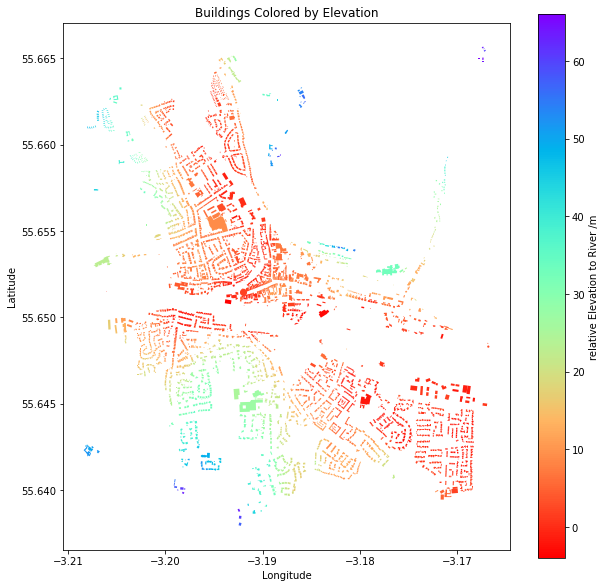

In [25]:
#Plot
colourmap = np.arange(buildings['relative elevation'].min(), buildings['relative elevation'].max(), 5)
cmap = plt.get_cmap('rainbow_r')

fig, ax = plt.subplots(figsize=(10, 10))

buildings.plot(column='relative elevation', cmap=cmap, ax=ax)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Buildings Colored by Elevation')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(colourmap)  
cbar = plt.colorbar(sm, ax=ax, label='relative Elevation to River /m')


# Display the plot
plt.show()

This is based off of the coordinate distances. This may be skewed due to the fact that the lat and lon distances are not inherently the same length. 

## Evaluation

In [26]:
buildings['dif'] = buildings['relative elevation'] - buildings['simple elevation']

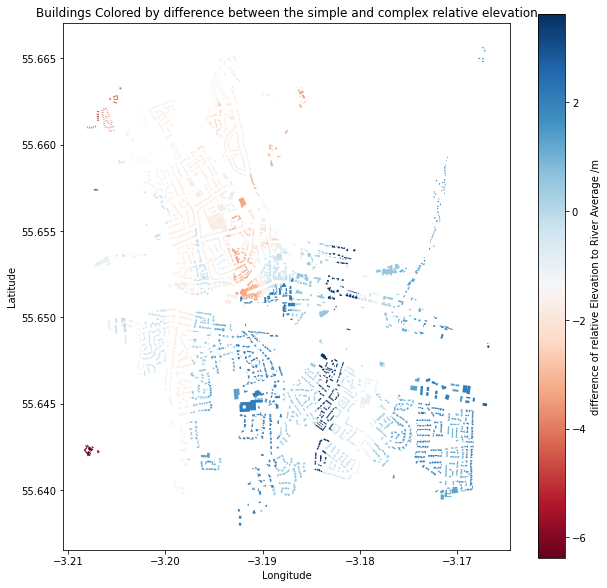

In [27]:
#Plot
colourmap = np.arange(buildings['dif'].min(), buildings['dif'].max(), 5)
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=(10, 10))

buildings.plot(column='dif', cmap=cmap, ax=ax)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Buildings Colored by difference between the simple and complex relative elevation')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(colourmap)  
cbar = plt.colorbar(sm, ax=ax, label='difference of relative Elevation to River Average /m')


# Display the plot
plt.show()

This shows the relative difference between the previous two ways of calculating the elevation. This shows that the simple elevation model, due to assuming a flat river makes the relative risk at the eastern end of the river worse. This is downstream, and is lower than the western end of the river, as shown in the elevation widget plot. 
Adding in elevation based on closest river distance helps to eliminate some bias from this river shift. 

# Final Module 

In [28]:
north = 55.6658  # North latitude
south = 55.6372  # South latitude
east = -3.1651   # East longitude
west = -3.2116   # West longitude

name = 'Exeter'
geotiff_path = 'Peebles-30m-DEM.tif'

In [29]:
#Needed packages for definition code
from shapely import Point
import numpy as np 
import hazards #<-- not needed in package. But much be replaced with .river_elevation module
import osmnx as ox
import rasterio 

In [30]:
def building_elev(name,*args):
    
    #River data loaded from other hazard module 
    r = hazards.river_elevation(name, *args, buffer = 0.005)
    
    #Absolute elevation of buildings
    if len(args) == 4:
        buildings = ox.features_from_bbox(*args, tags={'building' : True})
    elif len(args) == 1:
        buildings = ox.features_from_bbox(*args, tags={'building' : True})
    else:
        print(f'Incorrect number of arguments. Got {len(args)+1}, expected:')
        print('         2: link for geotiff elevation file, name of location recognised by OSM')
        print('         5: link for geotiff elevation file, north, south, east, west points of area')
    
    
    buildings['centroid'] = (buildings['geometry'].to_crs(crs=3857).centroid).to_crs(crs=4326) 
    coords_list = [(point.x, point.y) for point in buildings['centroid']] 
    
    elev = []
    
    with rasterio.open(geotiff_path) as src:
        vals = src.sample(coords_list)
        for val in vals:
            elev.append(val[0])
    buildings['elevation'] = elev
    
    
    #Building location info 
    building_loc = buildings['centroid'] 
    building_points = []
    for i in list(range(len(building_loc))):
        x, y = building_loc.iloc[i].xy
        points = [Point(x, y) for x, y in zip(x, y)]
        building_points = np.append(building_points, points)

    #river location and elevation info
    riv_points = []
    riv_elev = []
    for i in list(range(len(r['new geometry']))):
        rx, ry  = r['new geometry'].iloc[i].xy
        elev = r['elevations'].iloc[i]
        points = [Point(x, y) for x, y in zip(rx, ry)]
        riv_points = np.append(riv_points, points)
        riv_elev = np.append(riv_elev, elev)
        
    #Calculating relative elevation of the buildings 
    buildings['relative elevation'] = None

    for i in range(len(building_points)):
        p_index = building_points[i].distance(riv_points).argmin()
        elevation = riv_elev[p_index]
        rel_elev = buildings['elevation'].iloc[i] - elevation
        buildings['relative elevation'].iloc[i] = rel_elev         
    
    return buildings[['type', 'geometry','centroid' ,'building', 'elevation', 'relative elevation']]

In [31]:
build = building_elev('Peebles-30m-DEM.tif', north, south, east, west)

Processing rivers in lat long grid
2 Unique Rivers Extracted:
       River Tweed
       Eddleston Water


/tmp/ipykernel_4128023/1635620874.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buildings['relative elevation'].iloc[i] = rel_elev


## NOTE:
This has highlighted issues with the river_elevation module which must be fixed.